In [1]:
#| default_exp PETS

In [2]:
import os

# "MPS에서 지원 안 하는 연산은 CPU를 써라"고 허락해주는 설정
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [6]:
#hide
Path.BASE_PATH = path

In [7]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [8]:
(path/"images").ls()

(#7393) [Path('images/Egyptian_Mau_167.jpg'),Path('images/pug_52.jpg'),Path('images/basset_hound_112.jpg'),Path('images/Siamese_193.jpg'),Path('images/shiba_inu_122.jpg'),Path('images/Siamese_53.jpg'),Path('images/Birman_167.jpg'),Path('images/leonberger_6.jpg'),Path('images/Siamese_47.jpg'),Path('images/shiba_inu_136.jpg'),Path('images/saint_bernard_139.jpg'),Path('images/Birman_173.jpg'),Path('images/Abyssinian_225.jpg'),Path('images/basset_hound_106.jpg'),Path('images/miniature_pinscher_200.jpg'),Path('images/Siamese_187.jpg'),Path('images/wheaten_terrier_49.jpg'),Path('images/Egyptian_Mau_173.jpg'),Path('images/pug_46.jpg'),Path('images/shiba_inu_43.jpg')...]

In [9]:
fname = (path/"images").ls()[0]

In [10]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Egyptian_Mau']

In [19]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=42),
                get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms=Resize(224))
                #item_tfms=Resize(460),
                #batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

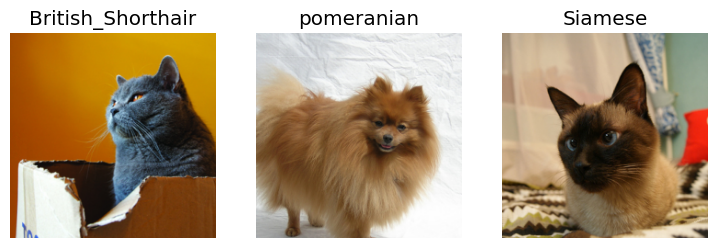

In [20]:
dls.show_batch(nrows=1, ncols=3)

In [21]:
#hide_output
# pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                  get_items=get_image_files, 
#                  splitter=RandomSplitter(seed=42),
#                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")

In [22]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.481171,0.318872,0.104871,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.455048,0.357330,0.106901,01:32
1,0.248208,0.227314,0.066982,01:34


In [23]:
x,y = dls.one_batch()

In [24]:
y

TensorCategory([23, 27,  9, 14, 30, 19, 29, 28, 25, 14, 12, 29, 27, 13,  6, 19, 16, 22, 17, 13, 30,  5, 19, 36,  2, 25,  4, 27, 25, 27, 13,  6, 20, 16,  7, 28, 24, 29, 23, 22, 13, 28, 29, 36, 13, 10,
                 2, 21, 13, 15, 29,  7, 20,  5, 17, 30, 35,  5, 31,  1, 32, 21, 29,  5], device='mps:0')

In [25]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.7835e-10, 1.3464e-10, 9.1152e-08, 1.5472e-09, 9.8769e-09, 2.6975e-10, 8.2108e-08, 1.0706e-06, 1.2024e-08, 7.8089e-11, 1.0583e-08, 5.5053e-09, 1.6415e-08, 7.9290e-11, 1.4788e-09, 3.1405e-08,
        7.6755e-08, 3.0299e-07, 1.7813e-09, 1.2807e-08, 2.6856e-09, 8.1595e-10, 9.2331e-10, 1.0000e+00, 1.9046e-09, 1.1284e-08, 3.1372e-09, 1.0471e-09, 9.9049e-08, 1.4461e-07, 3.4129e-07, 2.9623e-09,
        1.3138e-09, 1.2648e-09, 1.6910e-10, 3.2287e-10, 1.4242e-07])

In [26]:

len(preds[0]),preds[0].sum()

(37, tensor(1.))

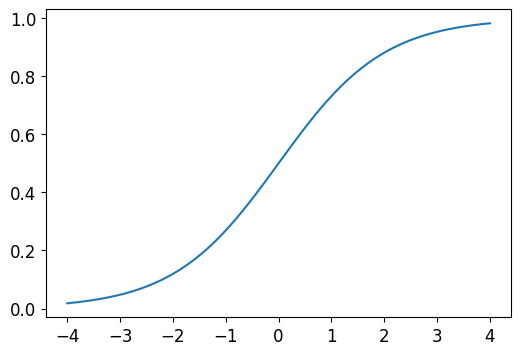

In [27]:
#소프트맥스
plot_function(torch.sigmoid, min=-4,max=4)

In [28]:
#hide
torch.random.manual_seed(42);

In [ ]:
#3이 될 확률과 7이 될 활서화 값
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [30]:
#확률 변환
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [31]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [32]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [35]:
#소프트맥스는 시그모이드의 다중버전이라고 볼 수 있음
#지수함수로 모든 숫자를 양수화 하고 이들을 합한 값으로 각 숫자를 나누면, 더했을 때 1이 되는 숫자가 여럿 생긴다

#교차 엔트로피 손실 함수는 두 부분으로 구성. 1.소프트맥스, 2.로그 가능도

In [36]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

In [37]:
targ = tensor([0,1,0,1,1,0])

In [38]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [39]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
# sm_acts[idx, targ] 와 같은 일을 하는 nll_loss 함수를 pytorch에서 제공
# NLL (Negative Log Likelihood) : 음의 로그 가능도
# NLL은 실제로 로그를 사용하진 않음. 이미 로그가 적용되었다고 가정함. (log_softmax -> nll_loss)

-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [41]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

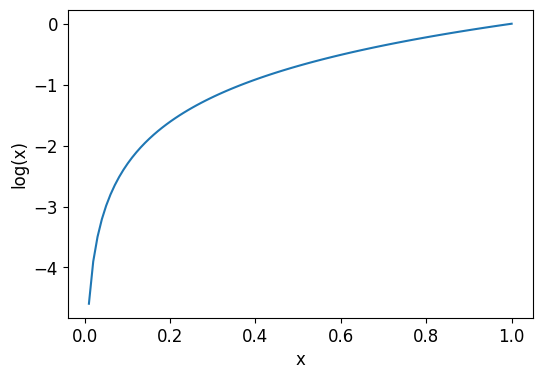

In [42]:
# 로그 취하기
# 모델은 예측값 0.99와 0.999를 10배 차이난다고 인식
# 0~1사이 값을 음의 무한대와 양의 무한대로 변환해야함. 그래야 차이가 극명하게 갈림
# 그래서 로그를 사용함
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

In [43]:
# 소프트맥스 -> 로그가능도 -> 교차 엔트로피 손실
loss_func = nn.CrossEntropyLoss()

In [ ]:
# 파이토치의 모든 손실 함수는 아래 2가지 형식으로 제공
# 1. 클래스 형식
loss_func(acts,targ)

tensor(1.8045)

In [ ]:
# 2. F 네임스페이스 일반 함수 형식
F.cross_entropy(acts,targ)

tensor(1.8045)

In [47]:
# 기본적으로 파이토치 손실 함수는 모든 항목의 평균 손실을 계산.
# 이를 막는게 reduction='none' 옵션
nn.CrossEntropyLoss(reduction='none' )(acts,targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])